In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pybrain.datasets import SupervisedDataSet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from pybrain.tools.shortcuts import buildNetwork
from pybrain.datasets import SupervisedDataSet
from pybrain.supervised.trainers import BackpropTrainer
from pybrain.structure.modules import TanhLayer, LinearLayer
import statsmodels.api as sm
from pybrain.structure import FullConnection
import pickle

In [2]:
data = pd.read_csv('/tmp/Task 5/UE_06_dataset04_joint_scraped_data.csv')
data.head()

,x,y
0,0.211976,6.694553e-159
1,0.087438,6.960205e-159
2,0.818725,5.560001e-158
3,0.950282,5.445055e-158
4,0.047747,8.367187e-159


In [3]:
data.columns = ["x", "y"]
data = data.apply(pd.to_numeric, errors='coerce')
data.dropna(inplace=True)  # Drop rows with missing values
data.drop_duplicates(inplace=True)  # Remove duplicate rows

In [4]:
# Handle outliers using Z-score
for column in data.select_dtypes(include=np.number).columns:
    z_scores = (data[column] - data[column].mean()) / data[column].std()
    data = data[(z_scores.abs() < 2)]

In [5]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

In [6]:
for column in data.select_dtypes(include=np.number).columns:
    data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())

In [7]:
X =  data.iloc[:, :-1].values  # Features
y =  data.iloc[:, -1].values  # Target

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))  # Reshape y to 2D

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)
y_pred_ols = ols_model.predict(X_test)
print(f"OLS Model - MSE: {mean_squared_error(y_test, y_pred_ols)}, R2: {r2_score(y_test, y_pred_ols)}")

OLS Model - MSE: 0.005182721696367033, R2: 0.9029746684121528


In [11]:
input_size = X_train.shape[1]
ann = buildNetwork(input_size, 5, 1)  # Simple feedforward network

train_ds = SupervisedDataSet(input_size, 1)

for i in range(len(X_train)):
    train_ds.addSample(X_train[i], y_train[i])

model = BackpropTrainer(ann, train_ds, learningrate=0.01, momentum=0.9)
model.trainUntilConvergence(maxEpochs=100)

([np.float64(0.0036414803559014918),
  np.float64(0.0026371356421255546),
  np.float64(0.0025834670433200297),
  np.float64(0.002576187874671628),
  np.float64(0.0026030101886058967),
  np.float64(0.0026376505173848),
  np.float64(0.002646684464644939),
  np.float64(0.002615606867014392),
  np.float64(0.0026091154480657355),
  np.float64(0.0026091423052516955),
  np.float64(0.0025694814790771323),
  np.float64(0.002606551652749915),
  np.float64(0.0025908893197731284),
  np.float64(0.0025816850779588076),
  np.float64(0.0025610032079667238),
  np.float64(0.0025762061085437705),
  np.float64(0.002576050136288283),
  np.float64(0.002602505248176955),
  np.float64(0.0025885996964770926),
  np.float64(0.002584903808436689),
  np.float64(0.0025641659589989174),
  np.float64(0.0025641774955487175),
  np.float64(0.0025575498309998103),
  np.float64(0.002575172012475243),
  np.float64(0.002600418609594755),
  np.float64(0.00254183049981213),
  np.float64(0.0025676680641218397),
  np.float64(0.

In [12]:
ann_model = 'UE_05_App3_ANN_Model.pkl'
with open(ann_model, 'wb') as f:
    pickle.dump(ann, f)

In [13]:
with open(ann_model, 'rb') as f:
    loaded_network = pickle.load(f)

In [14]:
y_pred_ols = ols_model.predict(X_test)
y_pred_ann = np.array([ann.activate(x) for x in X_test]).flatten()

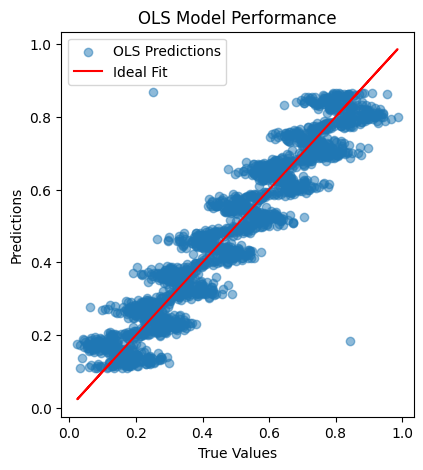

In [15]:
plt.figure(figsize=(10, 5))

# Plot OLS predictions
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_ols, alpha=0.5, label="OLS Predictions")
plt.plot(y_test, y_test, color="red", label="Ideal Fit")
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.savefig('OLS.pdf')
plt.title("OLS Model Performance")
plt.legend()
plt.show()
plt.close()

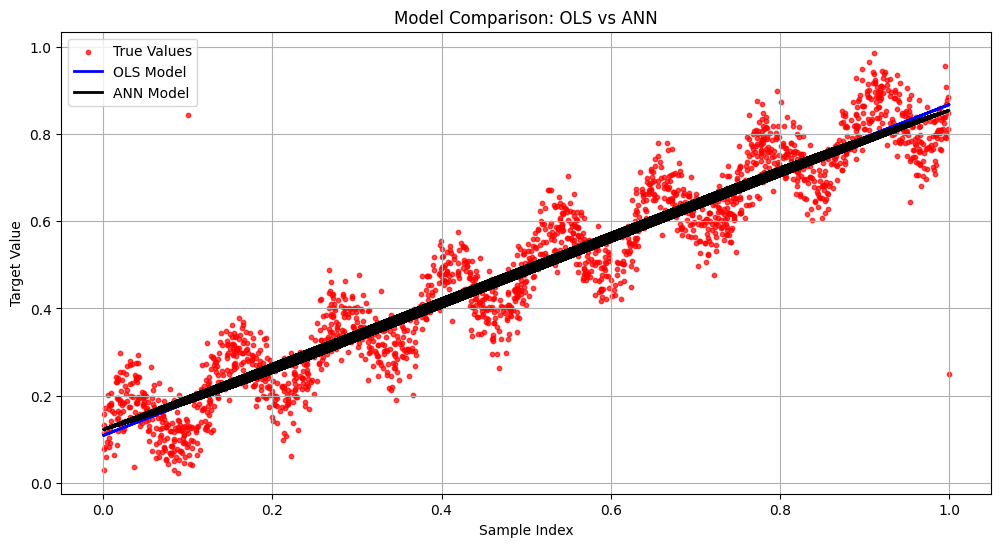

In [16]:
# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(X_test, y_test, color='red', label='True Values', alpha=0.7, s=10)  # True data points
plt.plot(X_test, y_pred_ols, color='blue', label='OLS Model', linewidth=2)  # OLS predictions
plt.plot(X_test, y_pred_ann, color='black', label='ANN Model', linewidth=2)  # ANN predictions

plt.title("Model Comparison: OLS vs ANN")
plt.xlabel("Sample Index")
plt.ylabel("Target Value")
plt.legend()
plt.grid(True)
plt.show()